# Climate Change Analysis 
* Student name: Chris Hollman
* Student pace: Self paced
* Scheduled review date/time: 
* Instructor name: Abhineet Kulkarni

## Project Overview
The goal of this project is to study the trends of our global climate. This will include an analysis of historical data, a prediction of future trends, and a regresssion model to determine associated factors. 

In [269]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
import seaborn as sns
sns.set_style('darkgrid')
import datetime
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from neuralprophet import NeuralProphet
import warnings
from sklearn.metrics import mean_absolute_error

In [270]:
country_df = pd.read_csv('data/GlobalLandTemperaturesByCountry.csv')
global_df = pd.read_csv('data/GlobalTemperatures.csv')
hist_gas_df = pd.read_csv('data/historical_emissions.csv')
pop_df = pd.read_csv('data/20_year_world_pop.csv')
gdp_df = pd.read_csv('data/gdp_growth.csv')
    

## Initial Data Exploration

In [271]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3192 entries, 0 to 3191
Data columns (total 9 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   dt                                         3192 non-null   object 
 1   LandAverageTemperature                     3180 non-null   float64
 2   LandAverageTemperatureUncertainty          3180 non-null   float64
 3   LandMaxTemperature                         1992 non-null   float64
 4   LandMaxTemperatureUncertainty              1992 non-null   float64
 5   LandMinTemperature                         1992 non-null   float64
 6   LandMinTemperatureUncertainty              1992 non-null   float64
 7   LandAndOceanAverageTemperature             1992 non-null   float64
 8   LandAndOceanAverageTemperatureUncertainty  1992 non-null   float64
dtypes: float64(8), object(1)
memory usage: 224.6+ KB


There are columns for both land and land/ocean min, max, and average temperatures. The ocean temperatures seem to have not been recorded until around l00 years later than lade temps. 

In [272]:
#Converting time stamp column to datetime format
global_df['dt'] = pd.to_datetime(global_df['dt'])

In [273]:
print("lowest uncertainty:", global_df['LandAverageTemperatureUncertainty'].min())
print("highest uncertainty:", global_df['LandAverageTemperatureUncertainty'].max())

lowest uncertainty: 0.034
highest uncertainty: 7.88


There is an extremely large difference in uncertainty as recording methods have become more sophisticated. The highest uncertaintly is +/- 7.88 degrees Celcius (14.8 degrees Farenheit). I've decided to trim the least accurate quartile of data.

In [274]:
global_df['LandAverageTemperatureUncertainty'].describe()

count    3180.000000
mean        0.938468
std         1.096440
min         0.034000
25%         0.186750
50%         0.392000
75%         1.419250
max         7.880000
Name: LandAverageTemperatureUncertainty, dtype: float64

In [275]:
#as expected the uncertainty early on is on the high side
global_df.head()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
0,1750-01-01,3.034,3.574,NaN,NaN,NaN,NaN,NaN,NaN
1,1750-02-01,3.083,3.702,NaN,NaN,NaN,NaN,NaN,NaN
2,1750-03-01,5.626,3.076,NaN,NaN,NaN,NaN,NaN,NaN
3,1750-04-01,8.490,2.451,NaN,NaN,NaN,NaN,NaN,NaN
4,1750-05-01,11.573,2.072,NaN,NaN,NaN,NaN,NaN,NaN


In [276]:
#more recent temperatures are accurate within +/- two tenths of a degree Farenheit
global_df.tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
3187,2015-08-01,14.755,0.072,20.699,0.110,9.005,0.170,17.589,0.057
3188,2015-09-01,12.999,0.079,18.845,0.088,7.199,0.229,17.049,0.058
3189,2015-10-01,10.801,0.102,16.450,0.059,5.232,0.115,16.290,0.062
3190,2015-11-01,7.433,0.119,12.892,0.093,2.157,0.106,15.252,0.063
3191,2015-12-01,5.518,0.100,10.725,0.154,0.287,0.099,14.774,0.062


In [277]:
#determining the latest month with an uncertainty greater than cutoff threshold
global_df[global_df['LandAverageTemperatureUncertainty']>1.4].tail()

,dt,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
1155,1846-04-01,7.473,1.729,NaN,NaN,NaN,NaN,NaN,NaN
1166,1847-03-01,4.046,1.583,NaN,NaN,NaN,NaN,NaN,NaN
1177,1848-02-01,3.726,1.437,NaN,NaN,NaN,NaN,NaN,NaN
1237,1853-02-01,2.228,1.492,8.29,1.535,-3.213,1.783,13.362,0.457
1260,1855-01-01,2.522,1.465,8.22,1.099,-3.125,1.699,13.384,0.442


In [278]:
#dropping all dates prior to 1856(the last year in which every recorded temp was within desired uncertainty range)
global_df = global_df[global_df['dt'] >= '1856']

In [279]:
#converting temps the Farenheit for interpretability
global_df['y'] = global_df['LandAverageTemperature']*1.8+32
global_df.rename(columns = {'dt':'ds'}, inplace = True)

In [280]:
#dropping unneccessary columns and formatting for Neural Prophet
drop_columns = ['LandAverageTemperature',
                'LandAverageTemperatureUncertainty',
                'LandMaxTemperature',
                'LandMaxTemperatureUncertainty',
                'LandMinTemperature',
                'LandMinTemperatureUncertainty',
                'LandAndOceanAverageTemperature',
                'LandAndOceanAverageTemperatureUncertainty']
ts = global_df.drop(drop_columns, axis=1)
ts.head()

,ds,y
1272,1856-01-01,36.9680
1273,1856-02-01,36.0068
1274,1856-03-01,39.8696
1275,1856-04-01,45.9518
1276,1856-05-01,50.9540


In [281]:
temp_1990_2000 = ts[ts['ds'].between('1990-01-01','2000-01-01')]
X = temp_1990_2000['ds']
y = temp_1990_2000['y']

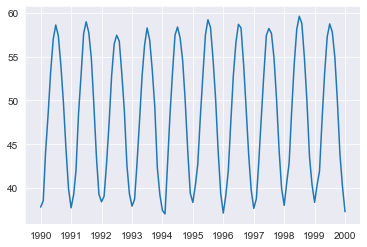

In [282]:
pd.plotting.register_matplotlib_converters()
ax = plt.plot(X,y)
plt.show()

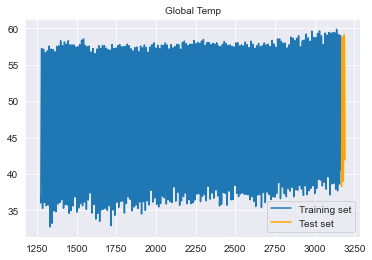

In [283]:
#splitting off last 2 years of data as a test set
test_size = 24

ts_train = ts[:-test_size]
ts_test = ts[-test_size:]

plt.title('Global Temp', size=10)
plt.plot(ts_train['y'], label='Training set')
plt.plot(ts_test['y'], label='Test set', color='orange')
plt.legend();

In [284]:
ts_test

,ds,y
3168,2014-01-01,38.7176
3169,2014-02-01,38.3000
3170,2014-03-01,43.4804
3171,2014-04-01,49.2602
3172,2014-05-01,54.6476
3173,2014-06-01,57.8030
3174,2014-07-01,58.7714
3175,2014-08-01,58.7750
3176,2014-09-01,55.5638
3177,2014-10-01,50.5940


In [285]:
m = NeuralProphet(loss_func='MAE', normalize=False)
m.fit(ts_train, freq = 'MS')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.614% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
ERROR - (NP.df_utils.get_normalization_params) - Normalization False not defined.
ERROR - (NP.df_utils.get_normalization_params) - Normalization False not defined.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 160


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.24E+00, min: 4.95E+00


  0%|          | 0/132 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 2.24E+00, min: 4.95E+00
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 7.96E-01
Epoch[160/160]: 100%|█| 160/160 [00:05<00:00, 30.04it/s, L1Loss=0.486, MAE=0.486


,L1Loss,MAE,RMSE,Loss,RegLoss
0,47.375430,47.375430,47.957038,35.644129,0.0
1,46.311353,46.311353,46.905733,34.793954,0.0
2,44.953090,44.953090,45.568422,33.706076,0.0
3,43.088396,43.088397,43.733582,32.210803,0.0
4,40.529512,40.529512,41.237145,30.167048,0.0
...,...,...,...,...,...
155,0.487392,0.487392,0.637933,0.354439,0.0
156,0.486963,0.486963,0.639795,0.354151,0.0
157,0.486254,0.486254,0.636419,0.353590,0.0
158,0.486267,0.486267,0.636017,0.353543,0.0


INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


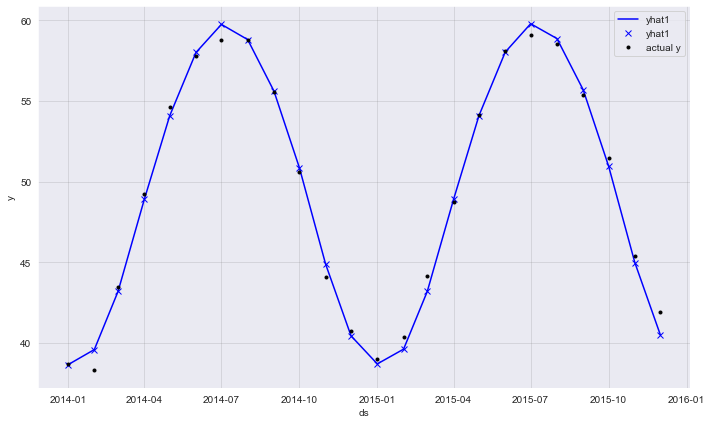

In [292]:
forecast = m.predict(ts_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast)

In [239]:
forecast

,ds,y,residual1,yhat1,trend,season_yearly
0,2014-01-01,38.7176,-0.058306,38.659294,49.419159,-10.759863
1,2014-02-01,38.3000,1.279956,39.579956,49.423069,-9.843112
2,2014-03-01,43.4804,-0.290340,43.190060,49.426601,-6.236542
3,2014-04-01,49.2602,-0.353214,48.906986,49.430515,-0.523531
4,2014-05-01,54.6476,-0.555368,54.092232,49.434303,4.657928
5,2014-06-01,57.8030,0.211992,58.014992,49.438217,8.576774
6,2014-07-01,58.7714,0.979641,59.751041,49.442001,10.309039
7,2014-08-01,58.7750,0.036295,58.811295,49.445915,9.365381
8,2014-09-01,55.5638,0.063889,55.627689,49.449825,6.177864
9,2014-10-01,50.5940,0.268019,50.862019,49.453613,1.408407


In [240]:
mean_absolute_error(forecast['y'], forecast['yhat1'])


0.46349898656209376

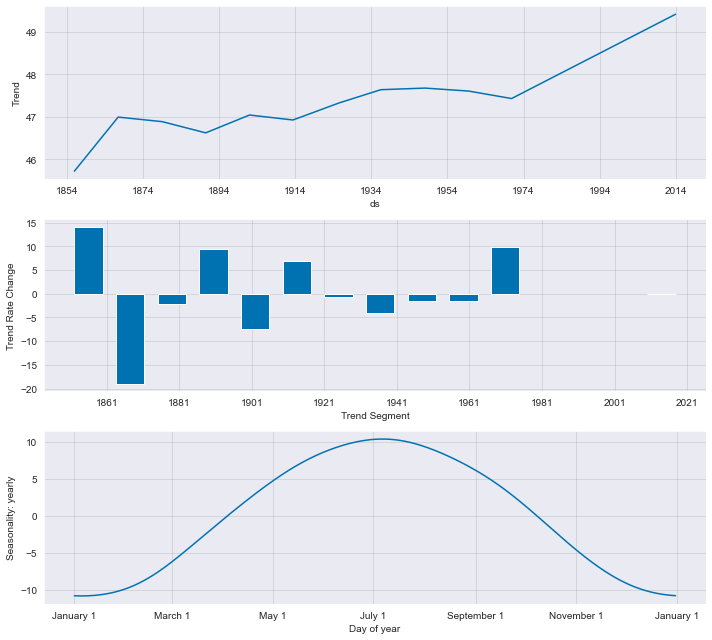

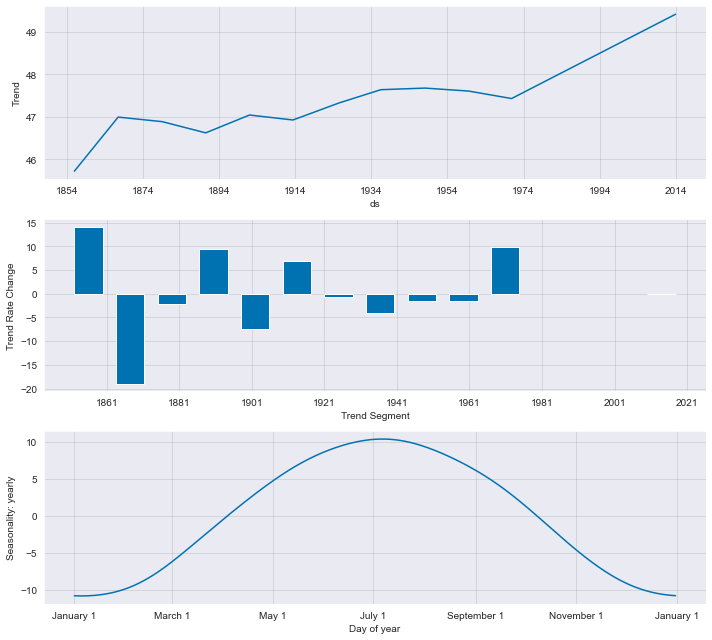

In [253]:
m.plot_parameters()


In [242]:
future_dates = m.make_future_dataframe(periods = 360, df = ts_test)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 87.5% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


In [243]:
forecast = m.predict(future_dates)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 91.389% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


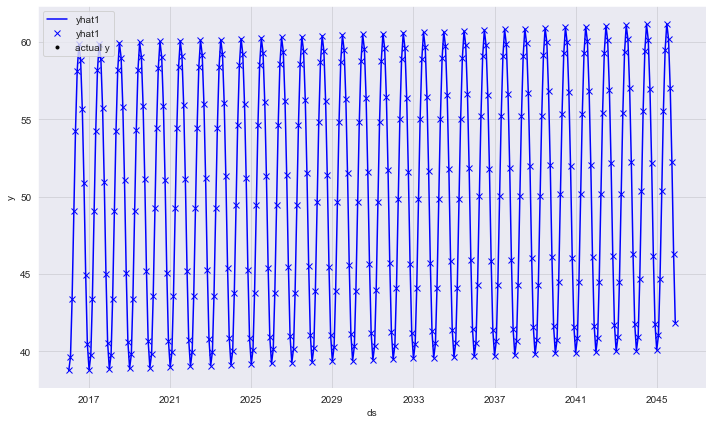

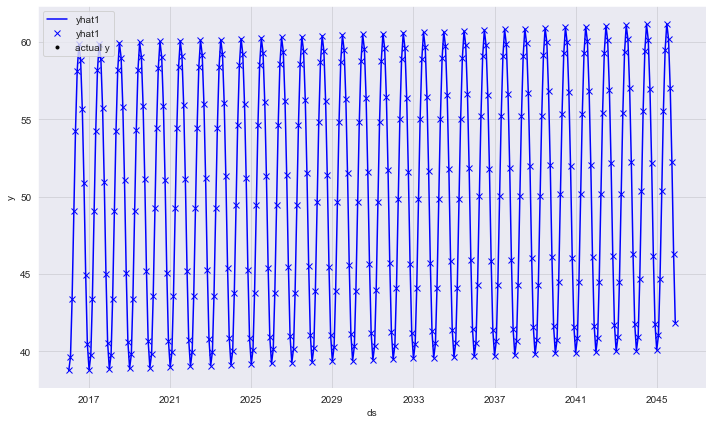

In [244]:
m.plot(forecast)

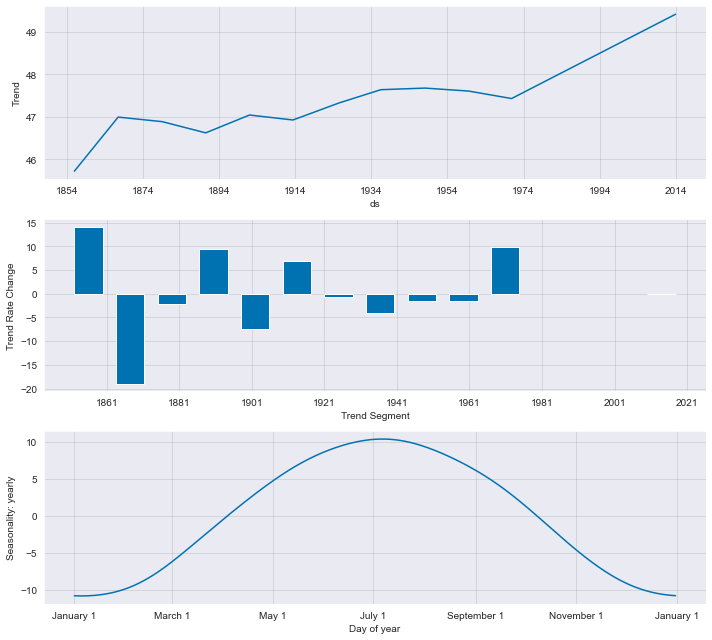

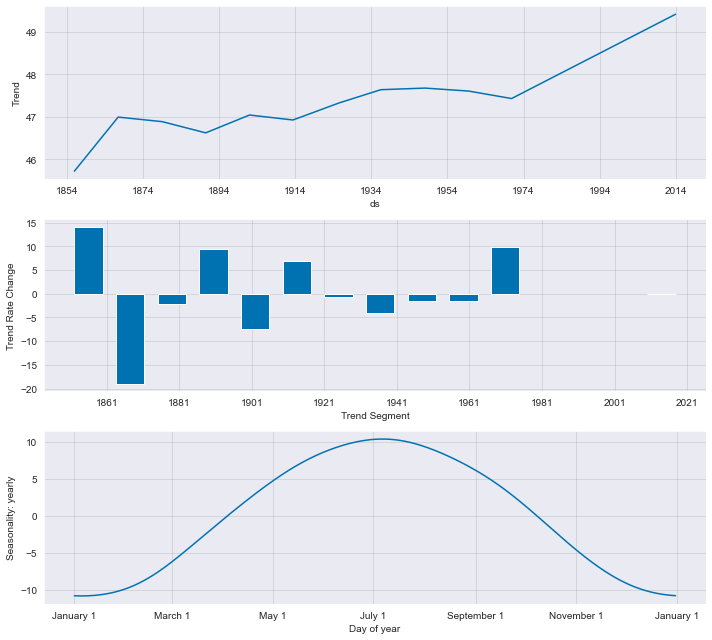

In [246]:
m.plot_parameters()

## Cleaning/Preprocessing